In [78]:
import pandas as pd
import pymorphy2 as pm
morph = pm.MorphAnalyzer()
import ast
from tqdm import tqdm_notebook

import random
from random import shuffle

import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import xgboost as xgb

In [2]:
matplotlib inline

In [11]:
dftrain, dftest = pd.read_csv("./trainTDIDF.csv"), pd.read_csv("./testTFIDF.csv")

In [4]:
from sklearn.metrics.pairwise import paired_cosine_distances

In [5]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import SnowballStemmer 
from nltk.corpus import stopwords

import string

In [12]:
dftest = dftest[['paragraph', 'paragraph_id', 'question',
       'question_id', 'target', 'sent_paragraph', 'num_sent_paragraph',
       'tokens_sent_paragraph', 'name_sent_paragraph', 'verb_sent_paragraph',
       'latn_sent_paragraph', 'adj_sent_paragraph', 'noun_sent_paragraph',
       'tokens_question_up', 'qw_nf_question_up', 'qw_question_up',
       'qw_long_question_up', 'name_question_up', 'verb_question_up',
       'latn_question_up', 'num_question_up', 'adj_question_up',
       'noun_question_up', 'best_sent', 'len_inr', 'len_name', 'len_verb',
       'len_latn', 'len_num', 'len_adj', 'len_noun',
       'tokens_paragraph_up']]

In [13]:
dftrain = dftrain[['paragraph', 'paragraph_id', 'question',
       'question_id', 'target', 'sent_paragraph', 'num_sent_paragraph',
       'tokens_sent_paragraph', 'name_sent_paragraph', 'verb_sent_paragraph',
       'latn_sent_paragraph', 'adj_sent_paragraph', 'noun_sent_paragraph',
       'tokens_question_up', 'qw_nf_question_up', 'qw_question_up',
       'qw_long_question_up', 'name_question_up', 'verb_question_up',
       'latn_question_up', 'num_question_up', 'adj_question_up',
       'noun_question_up', 'best_sent', 'len_inr', 'len_name', 'len_verb',
       'len_latn', 'len_num', 'len_adj', 'len_noun', 
       'tokens_paragraph_up']]

In [14]:
dftest = dftest.drop_duplicates()
dftrain = dftrain.drop_duplicates()

In [15]:
dftest.shape

(74290, 32)

In [16]:
dftrain.shape

(119398, 32)

In [34]:
pd=dftest.groupby(['question_id', 'paragraph_id']).agg({'paragraph_id': 'count'})

In [35]:
pd[pd['paragraph_id']>1]

,,paragraph_id
question_id,paragraph_id,


## Подготовка данных 

#### Частота по вопросам, параграфам 

In [17]:
test_question = dftest.groupby(['question']).agg({'paragraph_id': 'count'})
test_question = pd.DataFrame({'question': test_question.index, 'count_q': test_question.paragraph_id})
test_question['count_q'] = test_question['count_q'].astype(int)
dftest = dftest.merge(test_question, how = 'left', on='question')

In [18]:
test_par = dftest.groupby(['paragraph_id']).agg({'question_id': 'count'})
test_par = pd.DataFrame({'paragraph_id': test_par.index, 'count_p': test_par.question_id})
test_par['count_p'] = test_par['count_p'].astype(int)
dftest = dftest.merge(test_par, how = 'left', on='paragraph_id')

In [19]:
train_question = dftrain.groupby(['question']).agg({'paragraph_id': 'count'})
train_question = pd.DataFrame({'question': train_question.index, 'count_q': train_question.paragraph_id})
train_question['count_q'] = train_question['count_q'].astype(int)
dftrain = dftrain.merge(train_question, how = 'left', on='question')

In [20]:
train_par = dftrain.groupby(['paragraph_id']).agg({'question_id': 'count'})
train_par = pd.DataFrame({'paragraph_id': train_par.index, 'count_p': train_par.question_id})
train_par['count_p'] = train_par['count_p'].astype(int)
dftrain = dftrain.merge(train_par, how = 'left', on='paragraph_id')

#### TDIDF (по всем параграфам вопроса) 

In [21]:
questions_test = dftest.question_id.unique()

In [22]:
questions_train = dftrain.question_id.unique()

In [23]:
for name, qlist, df in [('train', questions_train, dftrain), ('test', questions_test, dftest)]: 
    pair_list=[]
    best_list=[]
    
    for i in tqdm_notebook(qlist, total=len(qlist), desc= name + ' questions'):
        scores=[]
        par_ids=list(df[df['question_id']==i]['paragraph_id'].unique())
        texts = list(df[df['question_id']==i]['tokens_paragraph_up'].unique())+\
        list(df[df['question_id']==i]['tokens_question_up'].unique())
        #print(texts)
        tfidf = TfidfVectorizer()
        tfidf_matrix=tfidf.fit_transform(texts)
        qvec = tfidf_matrix[len(texts)-1]
        for n, t in enumerate(texts):
            if n!=len(texts)-1:
                par=par_ids[n]
                svec = tfidf_matrix[n]
                score=float(paired_cosine_distances(svec,qvec))
                scores.append(score)
                pair_list.append([i, par, score])
            else:
                pass
        imin=np.argmin(scores)
        best_list.append([i, par_ids[imin], scores[imin]])
               
        
    labels = ['question_id', 'paragraph_id', 'score']
    labels_best = ['question_id', 'best_paragraph', 'best_score']
    dfscores = pd.DataFrame.from_records(pair_list, columns=labels)
    dfbest = pd.DataFrame.from_records(best_list, columns=labels_best)
    if name=='train':
        dftrain = dftrain.merge(dfscores, how = 'left', on=['question_id','paragraph_id'])
        dftrain = dftrain.merge(dfbest, how = 'left', on=['question_id'])
    else:
        dftest = dftest.merge(dfscores, how = 'left', on=['question_id','paragraph_id'])
        dftest = dftest.merge(dfbest, how = 'left', on=['question_id'])

In [24]:
dftest.shape

(74290, 37)

In [25]:
dftrain.shape

(119398, 37)

#### TDIDF (по всем вопросам параграфа) 

In [26]:
par_test = dftest.paragraph_id.unique()
par_train = dftrain.paragraph_id.unique()

In [27]:
for name, plist, df in [('train', par_train, dftrain), ('test', par_test, dftest)]: 
    pair_list=[]
    best_list=[]
    
    for i in tqdm_notebook(plist, total=len(plist), desc= name + ' paragraphs'):
        scores=[]
        q_ids=list(df[df['paragraph_id']==i]['question_id'].unique())
        texts = list(df[df['paragraph_id']==i]['tokens_question_up'].unique())+\
        list(df[df['paragraph_id']==i]['tokens_paragraph_up'].unique())
        tfidf = TfidfVectorizer()
        tfidf_matrix=tfidf.fit_transform(texts)
        pvec = tfidf_matrix[len(texts)-1]
        for n, t in enumerate(texts):
            if n!=len(texts)-1:
                quest=q_ids[n]
                svec = tfidf_matrix[n]
                score=float(paired_cosine_distances(svec,pvec))
                scores.append(score)
                pair_list.append([i, quest, score])
            else:
                pass
        imin=np.argmin(scores)
        best_list.append([i, q_ids[imin], scores[imin]])
               
        
    labels = ['paragraph_id', 'question_id', 'score1']
    labels_best = ['paragraph_id', 'best_question', 'best_score1']
    dfscores = pd.DataFrame.from_records(pair_list, columns=labels)
    dfbest = pd.DataFrame.from_records(best_list, columns=labels_best)
    if name=='train':
        dftrain = dftrain.merge(dfscores, how = 'left', on=['question_id','paragraph_id'])
        dftrain = dftrain.merge(dfbest, how = 'left', on=['paragraph_id'])
    else:
        dftest = dftest.merge(dfscores, how = 'left', on=['question_id','paragraph_id'])
        dftest = dftest.merge(dfbest, how = 'left', on=['paragraph_id'])

In [28]:
dftrain = dftrain.fillna(-1)
dftest = dftest.fillna(-1)

In [29]:
dftrain['dist'] = dftrain['score']-dftrain['best_score']
dftest['dist'] = dftest['score']-dftest['best_score']

In [30]:
dftrain['dist1'] = dftrain['score1']-dftrain['best_score1']
dftest['dist1'] = dftest['score1']-dftest['best_score1']

In [31]:
dftest.shape

(74290, 42)

In [32]:
dftrain.shape

(119398, 42)

In [36]:
#del dftrain['score_x']
#del dftrain['score_y']
#del dftest['score_x']
#del dftest['score_y']

#### Похожесть слов внутри вопроса (word2vec)

In [37]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

/Users/annavozmishcheva/anaconda/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [38]:
model = KeyedVectors.load_word2vec_format('./ruwikiruscorpora_0_300_20.bin', binary=True)

In [39]:
pos = list(['_NOUN', '_ADJ', '_VERB', '_ADV', '_INTJ', '_ADP', '_PART', '_NUM', '_DET', '_PRON'])
for key in tqdm_notebook(model.vocab.keys(), total=len(model.vocab.keys()), desc= ''):
    for p in pos:
        if key.endswith(p):
            repl = key.replace(p,'')
            #print(repl)
    if repl not in model.vocab.keys():
        model.vocab[repl] = model.vocab.pop(key)
    else:
        pass

In [40]:
for name, df in [('train', dftrain), ('test', dftest)]: 
    for index, row in tqdm_notebook(df.iterrows(), total=df.shape[0], desc= name + ' questions'):
        scores_q=[]
        for i, w in enumerate(ast.literal_eval(df.tokens_question_up.values[index])):
            scores=[]
            if w in model.vocab.keys():
                for j, w2 in enumerate(ast.literal_eval(df.tokens_question_up.values[index])):
                    if (w2 in model.vocab.keys())&(w2!=w):
                        scores.append(model.similarity(w, w2))
            avg_score = np.average(scores)
            scores_q.append(avg_score)
        avg_scores_q = np.average(scores_q)
        df.loc[index, 'w2v_question']=avg_scores_q

In [41]:
dftrain['w2v_question']=dftrain['w2v_question'].fillna(-1)

In [42]:
dftest['w2v_question']=dftest['w2v_question'].fillna(-1)

In [43]:
dftest.shape

(74290, 43)

#### Частота слов в вопросе  

In [45]:
dftest['frequency']=0.0
dftrain['frequency']=0.0
for dfname, quest, df in [('train','tokens_question_up', dftrain), 
                         ('test','tokens_question_up', dftest)]:
    for index, row in tqdm_notebook(df.iterrows(), total=df.shape[0], desc= dfname):
        len_uniq = len(set(ast.literal_eval(row[quest])))
        len_total = len(ast.literal_eval(row[quest]))
        df.loc[index, 'frequency'] = len_uniq/len_total 

#### Бейзлайн фичи 

In [49]:
for name, df in [('train', dftrain), ('test', dftest)]:
    for index, row in tqdm_notebook(df.iterrows(), total=df.shape[0], desc="build features for " + name):
        question = ast.literal_eval(df.tokens_question_up.values[index])
        paragraph = ast.literal_eval(df.tokens_paragraph_up[index])
        df.loc[index, 'len_paragraph'] = len(paragraph)
        df.loc[index, 'len_question'] = len(question)
        df.loc[index, 'len_intersection'] = len(set(question) & set(paragraph))

### Описание 

In [50]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119398 entries, 0 to 119397
Data columns (total 47 columns):
paragraph                119398 non-null object
paragraph_id             119398 non-null int64
question                 119398 non-null object
question_id              119398 non-null int64
target                   119398 non-null float64
sent_paragraph           119398 non-null object
num_sent_paragraph       119398 non-null object
tokens_sent_paragraph    119398 non-null object
name_sent_paragraph      119398 non-null object
verb_sent_paragraph      119398 non-null object
latn_sent_paragraph      119398 non-null object
adj_sent_paragraph       119398 non-null object
noun_sent_paragraph      119398 non-null object
tokens_question_up       119398 non-null object
qw_nf_question_up        119398 non-null object
qw_question_up           119398 non-null object
qw_long_question_up      119398 non-null object
name_question_up         119398 non-null object
verb_question_up         1

In [51]:
dftest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74290 entries, 0 to 74289
Data columns (total 47 columns):
paragraph                74290 non-null object
paragraph_id             74290 non-null int64
question                 74290 non-null object
question_id              74290 non-null int64
target                   74290 non-null float64
sent_paragraph           74290 non-null object
num_sent_paragraph       74290 non-null object
tokens_sent_paragraph    74290 non-null object
name_sent_paragraph      74290 non-null object
verb_sent_paragraph      74290 non-null object
latn_sent_paragraph      74290 non-null object
adj_sent_paragraph       74290 non-null object
noun_sent_paragraph      74290 non-null object
tokens_question_up       74290 non-null object
qw_nf_question_up        74290 non-null object
qw_question_up           74290 non-null object
qw_long_question_up      74290 non-null object
name_question_up         74290 non-null object
verb_question_up         74290 non-null object

## Частота вопросов, ответов

In [55]:
print('Train:')
print('Повторяющихся вопросов (вопросов, которые задаются нескольким параграфам): ' + str(len(dftrain[dftrain['count_q']>1].question.unique())))
print('Уникальных вопросов (вопросов, которые задаются только одному параграфу): ' + str(dftrain[dftrain['count_q']==1].question.count_q()))
print('Всего уникальных параграфов: ' + str(len(dftrain.paragraph.unique())))
print('Параграфов, к которым задаются повторяющиеся вопросы: ' + str(len(dftrain[dftrain['count_q']>1].paragraph.unique())))
print('Параграфов, к которым задаются уникальные вопросы: ' + str(len(dftrain[dftrain['count_q']==1].paragraph.unique())))
print()
print('Test:')
print('Повторяющихся вопросов (вопросов, которые задаются нескольким параграфам): ' + str(len(dftest[dftest['count_q']>1].question.unique())))
print('Уникальных вопросов (вопросов, которые задаются только одному параграфу): ' + str(dftest[dftest['count_q']==1].question.count_q()))
print('Всего уникальных параграфов: ' + str(len(dftest.paragraph.unique())))
print('Параграфов, к которым задаются повторяющиеся вопросы: ' + str(len(dftest[dftest['count_q']>1].paragraph.unique())))
print('Параграфов, к которым задаются уникальные вопросы: ' + str(len(dftest[dftest['count_q']==1].paragraph.unique())))

Train:
Повторяющихся вопросов (вопросов, которые задаются нескольким параграфам): 13800
Уникальных вопросов (вопросов, которые задаются только одному параграфу): 25068
Всего уникальных параграфов: 9078
Параграфов, к которым задаются повторяющиеся вопросы: 5855
Параграфов, к которым задаются уникальные вопросы: 8284

Test:
Повторяющихся вопросов (вопросов, которые задаются нескольким параграфам): 4237
Уникальных вопросов (вопросов, которые задаются только одному параграфу): 39103
Всего уникальных параграфов: 1627
Параграфов, к которым задаются повторяющиеся вопросы: 1389
Параграфов, к которым задаются уникальные вопросы: 1627


In [84]:
print('Train:')
print('Повторяющихся параграфов (параграфов, к которым задаются несколько вопросов): ' + str(len(dftrain[dftrain['count_p']>1].paragraph.unique())))
print('Уникальных параграфов (параграфов, к которым задается один вопрос): ' + str(dftrain[dftrain['count_p']==1].paragraph.count()))
print('Всего уникальных вопросов: ' + str(len(dftrain.question.unique())))
print('Вопросов, которые задаются повторяющимся параграфам: ' + str(len(dftrain[dftrain['count_p']>1].question.unique())))
print('Вопросов, которые задаются уникальным параграфам: ' + str(len(dftrain[dftrain['count_p']==1].question.unique())))
print()
print('Test:')
print('Повторяющихся параграфов (параграфов, к которым задаются несколько вопросов): ' + str(len(dftest[dftest['count_p']>1].paragraph.unique())))
print('Уникальных параграфов (параграфов, к которым задается один вопрос): ' + str(dftest[dftest['count_p']==1].paragraph.count()))
print('Всего уникальных вопросов: ' + str(len(dftest.question.unique())))
print('Вопросов, которые задаются повторяющимся параграфам: ' + str(len(dftest[dftest['count_p']>1].question.unique())))
print('Вопросов, которые задаются уникальным параграфам: ' + str(len(dftest[dftest['count_p']==1].question.unique())))

Train:
Повторяющихся параграфов (параграфов, к которым задаются несколько вопросов): 7777
Уникальных параграфов (параграфов, к которым задается один вопрос): 1301
Всего уникальных вопросов: 38868
Вопросов, которые задаются повторяющимся параграфам: 37941
Вопросов, которые задаются уникальным параграфам: 1301

Test:
Повторяющихся параграфов (параграфов, к которым задаются несколько вопросов): 1627
Уникальных параграфов (параграфов, к которым задается один вопрос): 0
Всего уникальных вопросов: 43340
Вопросов, которые задаются повторяющимся параграфам: 43340
Вопросов, которые задаются уникальным параграфам: 0


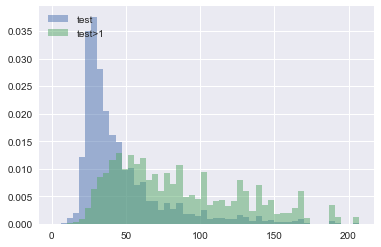

In [89]:
kwargs = dict(alpha=0.5, normed=True, bins=50)
plt.hist(dftest[dftest['count_q']==1]['count_p'], label = 'test', **kwargs)
plt.hist(dftest[dftest['count_q']>1]['count_p'], label = 'test>1', **kwargs)
plt.legend(loc='upper left')
plt.show()

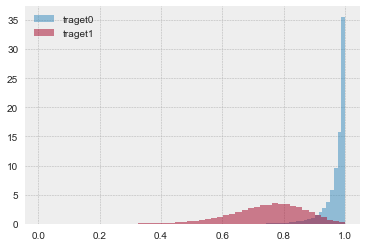

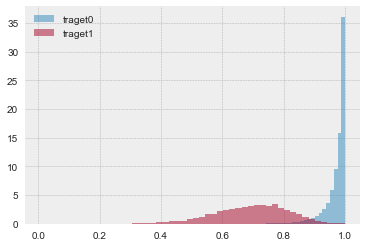

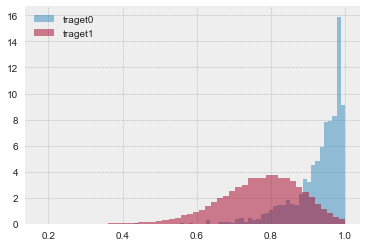

In [238]:
kwargs = dict(alpha=0.5, normed=True, bins=50)
#n, bins, patches=plt.hist(h[h['distance']>-99]['distance'], **kwargs)
plt.hist(dftrain[(dftrain['target']==0)]['score'], label='traget0', **kwargs)
plt.hist(dftrain[(dftrain['target']==1)]['score'], label='traget1', **kwargs)
plt.legend(loc='upper left')
plt.show()

plt.hist(dftrain[(dftrain['target']==0)&(dftrain['count']>1)]['score'], label='traget0', **kwargs)
plt.hist(dftrain[(dftrain['target']==1)&(dftrain['count']>1)]['score'], label='traget1', **kwargs)
plt.legend(loc='upper left')
plt.show()

plt.hist(dftrain[(dftrain['target']==0)&(dftrain['count']==1)]['score'], label='traget0', **kwargs)
plt.hist(dftrain[(dftrain['target']==1)&(dftrain['count']==1)]['score'], label='traget1', **kwargs)
plt.legend(loc='upper left')
plt.show()

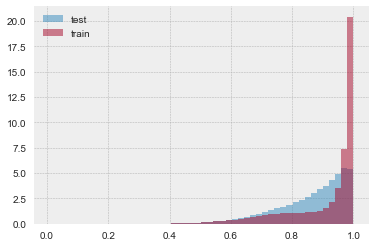

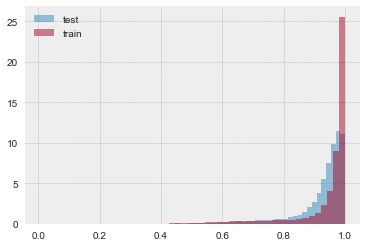

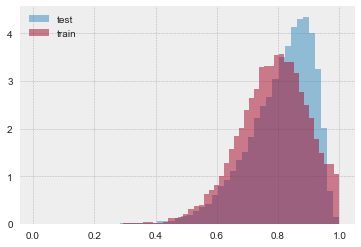

In [239]:
plt.hist(dftest['score'], label = 'test', **kwargs)
plt.hist(dftrain['score'], label = 'train', **kwargs)
plt.legend(loc='upper left')
plt.show()

plt.hist(dftest[dftest['count']>1]['score'], label = 'test', **kwargs)
plt.hist(dftrain[dftrain['count']>1]['score'], label = 'train', **kwargs)
plt.legend(loc='upper left')
plt.show()

plt.hist(dftest[dftest['count']==1]['score'], label = 'test', **kwargs)
plt.hist(dftrain[dftrain['count']==1]['score'], label = 'train', **kwargs)
plt.legend(loc='upper left')
plt.show()

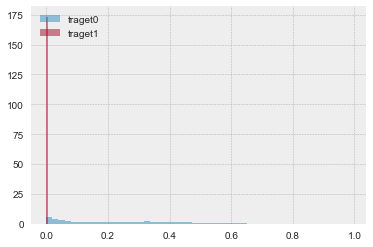

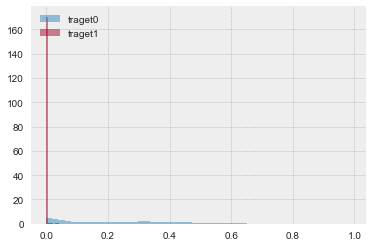

In [240]:
kwargs = dict(alpha=0.5, normed=True, bins=50)
#n, bins, patches=plt.hist(h[h['distance']>-99]['distance'], **kwargs)
plt.hist(dftrain[(dftrain['target']==0)]['dist'], label='traget0', **kwargs)
plt.hist(dftrain[(dftrain['target']==1)]['dist'], label='traget1', **kwargs)
plt.legend(loc='upper left')
plt.show()

plt.hist(dftrain[(dftrain['target']==0)&(dftrain['count']>1)]['dist'], label='traget0', **kwargs)
plt.hist(dftrain[(dftrain['target']==1)&(dftrain['count']>1)]['dist'], label='traget1', **kwargs)
plt.legend(loc='upper left')
plt.show()

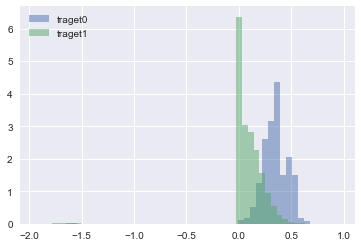

In [118]:
kwargs = dict(alpha=0.5, normed=True, bins=50)
#n, bins, patches=plt.hist(h[h['distance']>-99]['distance'], **kwargs)
plt.hist(dftrain[(dftrain['target']==0)]['dist1'], label='traget0', **kwargs)
plt.hist(dftrain[(dftrain['target']==1)]['dist1'], label='traget1', **kwargs)
plt.legend(loc='upper left')
plt.show()

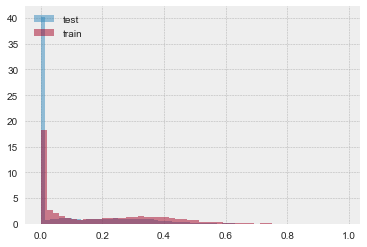

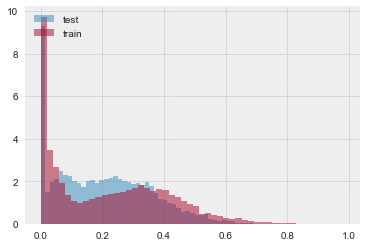

In [106]:
plt.hist(dftest['dist'], label = 'test', **kwargs)
plt.hist(dftrain['dist'], label = 'train', **kwargs)
plt.legend(loc='upper left')
plt.show()

plt.hist(dftest[dftest['count']>1]['dist'], label = 'test', **kwargs)
plt.hist(dftrain[dftrain['count']>1]['dist'], label = 'train', **kwargs)
plt.legend(loc='upper left')
plt.show()

In [311]:
dftest[(dftest['count']==1)&(dftest['score']>0.9)].question.values[19]

'Сколько копий альбома было изображено механически и евро, наиболее распространены соревнования одиночные турниры мужчины джон изнер четвертьфинал основной турнир одиночный разряд nbsp юноши nbsp девушки?'

In [307]:
dftest[(dftest['count']==1)&(dftest['score']>0.9)].paragraph.values[16]

'Отношение предпочтения в теории потребления — это формальное описание способности потребителя сравнивать (упорядочивать по желательности) разные наборы товаров (потребительские наборы, альтернативы). Чтобы описать отношение предпочтения, не обязательно измерять желательность каждого потребительского набора в некоторых единицах измерения, следует только подать любой метод сравнения таких наборов (порядковый подход). Отношение предпочтения является, наряду с бюджетным ограничением, базовым понятием при формальной постановке задачи о выборе потребителя.'

In [119]:
plt.hist(dftest['w2v_question'], label = 'test', **kwargs)
plt.hist(dftrain['w2v_question'], label = 'train', **kwargs)
plt.legend(loc='upper left')
plt.show()

plt.hist(dftest[dftest['count']==1]['w2v_question'], label = 'test', **kwargs)
plt.hist(dftrain[dftrain['count']==1]['w2v_question'], label = 'train', **kwargs)
plt.legend(loc='upper left')
plt.show()

KeyError: 'w2v_question'

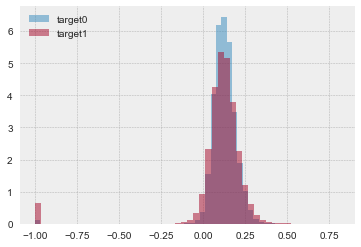

In [465]:
plt.hist(dftrain[dftrain['target']==0]['fake'], label = 'target0', **kwargs)
plt.hist(dftrain[dftrain['target']==1]['fake'], label = 'target1', **kwargs)
plt.legend(loc='upper left')
plt.show()

# Модель 

In [52]:
dftrain.shape

(119398, 47)

In [53]:
dftest.shape

(74290, 47)

In [54]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [55]:
#del dftest['prediction']

### Часть 1 

In [56]:
dftrain.columns

Index(['paragraph', 'paragraph_id', 'question', 'question_id', 'target',
       'sent_paragraph', 'num_sent_paragraph', 'tokens_sent_paragraph',
       'name_sent_paragraph', 'verb_sent_paragraph', 'latn_sent_paragraph',
       'adj_sent_paragraph', 'noun_sent_paragraph', 'tokens_question_up',
       'qw_nf_question_up', 'qw_question_up', 'qw_long_question_up',
       'name_question_up', 'verb_question_up', 'latn_question_up',
       'num_question_up', 'adj_question_up', 'noun_question_up', 'best_sent',
       'len_inr', 'len_name', 'len_verb', 'len_latn', 'len_num', 'len_adj',
       'len_noun', 'tokens_paragraph_up', 'count_q', 'count_p', 'score',
       'best_paragraph', 'best_score', 'score1', 'best_question',
       'best_score1', 'dist', 'dist1', 'w2v_question', 'frequency',
       'len_paragraph', 'len_question', 'len_intersection'],
      dtype='object')

In [58]:
cols = ['len_inr',
        'len_name', 
        'len_verb', 
        'len_latn', 
        'len_num', 
        'len_adj', 
        'len_noun',
        'score',
        'best_score',
        'dist',
        'frequency', 'w2v_question', 'len_paragraph', 'len_question',
        #'cosine_distance',
        'len_intersection', 
        'score1', 'best_score1', 'dist1']

y = dftrain[dftrain['count_q']>1]['target']
#train=train[features]

In [59]:
Xtr, Xv, ytr, yv = train_test_split(dftrain[dftrain['count_q']>1][cols].values, y, test_size=0.2)

In [60]:
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(dftest[dftest['count_q']>1][cols].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

params ={
        'eta':0.03,
        'n_estimators': 3000,
        'max_depth': 5,
        'objective': 'binary:logistic',
        'eval_metric': 'auc'
        }

In [61]:
xgb_model = xgb.train(params = params, dtrain = dtrain, evals=watchlist, num_boost_round = params['n_estimators'], verbose_eval=100, early_stopping_rounds=100)

[0]	train-auc:0.994787	valid-auc:0.994236
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[100]	train-auc:0.998846	valid-auc:0.998602
[200]	train-auc:0.999362	valid-auc:0.998864
[300]	train-auc:0.999495	valid-auc:0.998966
[400]	train-auc:0.999598	valid-auc:0.999006
[500]	train-auc:0.999679	valid-auc:0.999021
[600]	train-auc:0.999748	valid-auc:0.999032
[700]	train-auc:0.999799	valid-auc:0.999037
Stopping. Best iteration:
[650]	train-auc:0.999774	valid-auc:0.999041



In [62]:
dftest_part1 = dftest[dftest['count_q']>1]

In [63]:
dftest_part1['prediction'] = xgb_model.predict(dtest)

In [160]:
dftest_part1[(dftest_part1.prediction>0.5)].paragraph.values[10]

'Обычно устойчивость связывали и связывают с биоразнообразием видов в экосистеме (альфаразнообразие), то есть, чем выше биоразнообразие, чем сложнее организация сообществ, чем сложнее пищевые сети, тем выше устойчивость экосистем. Но уже 40 и более лет назад на данный вопрос существовали различные точки зрения, и на данный момент наиболее распространено мнение, что как локальная, так и общая устойчивость экосистемы зависят от значительно большего набора факторов, чем просто сложность сообществ и биоразнообразие. Так, на данный момент с повышением биоразнообразия обычно связывают повышение сложности, силы связей между компонентами экосистемы, стабильность потоков вещества и энергии между компонентами.'

In [161]:
dftest_part1[(dftest_part1.prediction>0.5)].question.values[10]

'Увеличение сложности связей в экосистеме с чем связывают сейчас?'

In [662]:
dftest.shape

(74414, 50)

In [663]:
dftest_part1[(dftest_part1.prediction>=0.5)].shape

(3823, 50)

In [664]:
dftest_part1[(dftest_part1.prediction<0.5)].shape

(31488, 50)

In [178]:
dftest_part1[(dftest_part1.prediction<=0.5)].paragraph.values[40]

'Ньютона часто считают сторонником корпускулярной теории света; на самом деле он, по своему обыкновению, гипотез не измышлял и охотно допускал, что свет может быть связан и с волнами в эфире. В трактате, представленном в Королевское общество в 1675 году, он пишет, что свет не может быть просто колебаниями эфира, так как тогда он, например, мог бы распространяться по изогнутой трубе, как это делает звук. Но, с другой стороны, он предлагает считать, что распространение света возбуждает колебания в эфире, что и порождает дифракцию и другие волновые эффекты. По существу, Ньютон, ясно сознавая достоинства и недостатки обоих подходов, выдвигает компромиссную, корпускулярно-волновую теорию света. В своих работах Ньютон детально описал математическую модель световых явлений, оставляя в стороне вопрос о физическом носителе света: Учение моё о преломлении света и цветах состоит единственно в установлении некоторых свойств света без всяких гипотез о его происхождении . Волновая оптика, когда она 

In [179]:
dftest_part1[(dftest_part1.prediction<=0.5)].question.values[40]

'Какие предположения, по мнению Ньютона, допустимы в натуральной философии (то есть физике)?'

In [253]:
ids=dftest_part1[(dftest_part1.prediction>0.5)].question_id.unique()

In [255]:
ids2=[i for i in dftest_part1.question_id.unique() if i not in ids]

In [257]:
len(ids2)

591

In [278]:
dftest_part1[dftest_part1.question_id==ids2[3]].paragraph.values[0]

'Понятие о грибах как об отдельном царстве сформировалось в науке к 1970-м годам, хотя выделить это царство предлагал ещё Э. Фрис в 1831 году, а Карл Линней высказывал сомнения, размещая грибы в царстве растений в своей Системе природы . Во второй половине XX века окончательно сформировалось и представление о полифилетизме грибов. К концу XX века были накоплены данные по генетике, цитологии и биохимии, позволившие разделить эту группу организмов на несколько не родственных между собой ветвей и распределить их между различными царствами, оставив в царстве настоящих , или собственно грибов, только одну из них. Таким образом, к началу XXI века научный термин грибы стал неоднозначным.'

In [279]:
dftest_part1[dftest_part1.question_id==ids2[3]].question.values[0]

'К чему были отнесены хитридиомицеты учеными в 1990-х годах?'

In [182]:
dftest_part1[(dftest_part1.prediction<=0.5)].question_id.values[30000]

34004

In [186]:
dftest_part1[(dftest_part1.prediction>0.5)&(dftest_part1.question_id==34004)].paragraph.values[0]

'С 1 января 2014 года Федеральный закон № 94-ФЗ утрачивает силу в связи со вступлением в действие Федерального закона от 05 апреля 2013 № 44-ФЗ О контрактной системе в сфере закупок товаров, работ, услуг для обеспечения государственных и муниципальных нужд . Этим законом определяется создание Единой информационной системы в сфере государственных закупок . Она представляет собой совокупность информации, информационных технологий и технических средств, обеспечивающих формирование, хранение и обработку данных в информационно-телекоммуникационной сети Интернет.'

In [184]:
dftest_part1[(dftest_part1.prediction>0.5)&(dftest_part1.question_id==34004)].question.values[0]

'Когда вступает в действие Федеральный закон № 44-ФЗ?'

In [193]:
dftest_part1[(dftest_part1.prediction>0.5)&(dftest_part1.question_id==19772)].question.values[0]

'Кем был Данте Алигьери?'

In [200]:
dftest_part1[(dftest_part1.prediction>0.5)&(dftest_part1.question_id==19772)].paragraph.values[3]

'Согласно семейному преданию, предки Данте происходили из римского рода Элизеев, участвовавших в основании Флоренции. Каччагвида, прапрадед Данте, участвовал в крестовом походе Конрада III (1147—1149), был посвящён им в рыцари и погиб в бою с мусульманами. Каччагвида был женат на даме из ломбардской семьи Альдигьери да Фонтана. Имя Альдигьери трансформировалось в Алигьери ; так был назван один из сыновей Каччагвиды. Сын этого Алигьери, Беллинчоне, дед Данте, изгонявшийся из Флоренции во время борьбы гвельфов и гибеллинов, вернулся в родной город в 1266 году, после поражения Манфреда Сицилийского при Беневенто. Алигьери II, отец Данте, видимо, не принимал участия в политической борьбе и оставался во Флоренции.'

In [ ]:
12242    4
19772    4
23915    3
14513    3
21842    3
29461    3
33596    3

### Часть 2

In [64]:
cols = ['len_inr',
        'len_name', 
        'len_verb', 
        'len_latn', 
        'len_num', 
        'len_adj', 
        'len_noun',
        'score',
        'best_score',
        'frequency', 'w2v_question', 'len_paragraph', 'len_question',
        'len_intersection','score1', 'best_score1']
y = dftrain['target']
#train=train[features]

In [65]:
Xtr, Xv, ytr, yv = train_test_split(dftrain[cols].values, y, test_size=0.2)

In [67]:
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(dftest[dftest['count_q']==1][cols].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

params ={
        'eta':0.03,
        'n_estimators': 3000,
        'max_depth': 5,
        'objective': 'binary:logistic',
        'eval_metric': 'auc'
        }

In [68]:
xgb_model = xgb.train(params = params, dtrain = dtrain, evals=watchlist, num_boost_round = params['n_estimators'], verbose_eval=100, early_stopping_rounds=500)

[0]	train-auc:0.990765	valid-auc:0.989597
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 500 rounds.
[100]	train-auc:0.997754	valid-auc:0.997406
[200]	train-auc:0.998587	valid-auc:0.998158
[300]	train-auc:0.998935	valid-auc:0.998385
[400]	train-auc:0.999103	valid-auc:0.99849
[500]	train-auc:0.99925	valid-auc:0.998553
[600]	train-auc:0.999357	valid-auc:0.998593
[700]	train-auc:0.999442	valid-auc:0.998618
[800]	train-auc:0.999524	valid-auc:0.998633
[900]	train-auc:0.999598	valid-auc:0.998647
[1000]	train-auc:0.999658	valid-auc:0.998658
[1100]	train-auc:0.999703	valid-auc:0.998668
[1200]	train-auc:0.999742	valid-auc:0.998681
[1300]	train-auc:0.999774	valid-auc:0.998686
[1400]	train-auc:0.999802	valid-auc:0.998686
[1500]	train-auc:0.999826	valid-auc:0.998689
[1600]	train-auc:0.999846	valid-auc:0.998689
[1700]	train-auc:0.999864	valid-auc:0.998691
[1800]	train-auc:0.999881	valid-auc:0.998693
[1900]	train-au

In [71]:
dftest_part2 = dftest[dftest['count_q']==1]

In [72]:
dftest_part2['prediction'] = xgb_model.predict(dtest)

In [73]:
dftest_part2[(dftest_part2.prediction>0.5)].question.values[33]

'Что башня, прикрывающая восточный фланг городских стен, была целиком окружают горы ведёт канатная дорога ведёт?'

In [74]:
dftest_part2[(dftest_part2.prediction>0.5)].paragraph.values[33]

'Северная от реки часть города называется Канбук ( к северу от реки ) и Каннам ( к югу от реки ). К Каннаму прилегает остров Ёыйдо. Среди притоков Хангана — Танчон, Чхонгечхон и другие. Исторический центр окружён горами Нэсасан (Четыре горы с внутренней стороны крепостной стены): Пугаксан с севера, Наксан с востока, Намсан с юга и Инвансан с запада. На расположенной вблизи исторического центра лесистой горе Намсан (Южная гора) возвышается Сеульская телевизионная башня, к которой ведёт канатная дорога. Город целиком окружают горы Весасан (Четыре горы с внешней стороны крепостной стены): Пукхансан (высотою до 836,5 м) с севера, Ёнмасан с востока, Кванаксан с юга и Тогянсан с запада.'

In [75]:
dftest_part2[(dftest_part2.prediction<=0.5)].shape

(18747, 48)

In [76]:
dftest_part2[(dftest_part2.prediction>0.5)].shape

(20356, 48)

In [79]:
dftest_results=pd.concat([dftest_part1, dftest_part2])

In [80]:
#del dftest['prediction']

In [81]:
dftest=dftest.merge(dftest_results[['paragraph_id','question_id','prediction']], how='left', on=['paragraph_id','question_id'])

In [545]:
dftest.columns

Index(['Unnamed: 0_x', 'Unnamed: 0.1', 'paragraph', 'paragraph_id', 'question',
       'question_id', 'target', 'sent_paragraph', 'num_sent_paragraph',
       'tokens_sent_paragraph', 'name_sent_paragraph', 'verb_sent_paragraph',
       'latn_sent_paragraph', 'adj_sent_paragraph', 'noun_sent_paragraph',
       'tokens_question_up', 'qw_nf_question_up', 'qw_question_up',
       'qw_long_question_up', 'name_question_up', 'verb_question_up',
       'latn_question_up', 'num_question_up', 'adj_question_up',
       'noun_question_up', 'best_sent', 'len_inr', 'len_name', 'len_verb',
       'len_latn', 'len_num', 'len_adj', 'len_noun', 'count',
       'tokens_paragraph_up', 'best_paragraph_x', 'best_score_x', 'dist',
       'score', 'best_paragraph_y', 'best_score_y', 'Unnamed: 0_y',
       'frequency', 'fake', 'len_paragraph', 'len_question', 'prediction'],
      dtype='object')

In [82]:
dftest[['paragraph_id', 'question_id', 'prediction']].to_csv("prediction.csv", index=False)

In [83]:
#dftest[dftest['count']>1].prediction.value_counts()

In [349]:
dftest.columns

Index(['Unnamed: 0', 'paragraph', 'paragraph_id', 'question', 'question_id',
       'target', 'sent_paragraph', 'num_sent_paragraph',
       'tokens_sent_paragraph', 'name_sent_paragraph', 'verb_sent_paragraph',
       'latn_sent_paragraph', 'adj_sent_paragraph', 'noun_sent_paragraph',
       'tokens_question_up', 'qw_nf_question_up', 'qw_question_up',
       'qw_long_question_up', 'name_question_up', 'verb_question_up',
       'latn_question_up', 'num_question_up', 'adj_question_up',
       'noun_question_up', 'best_sent', 'len_inr', 'len_name', 'len_verb',
       'len_latn', 'len_num', 'len_adj', 'len_noun', 'count',
       'tokens_paragraph_up', 'best_paragraph_x', 'best_score_x', 'dist',
       'score', 'best_paragraph_y', 'best_score_y'],
      dtype='object')

In [338]:
del dftest['prediction_x']

In [339]:
del dftest['prediction_y']

In [312]:
dftest.to_csv('./testTFIDF.csv')
dftrain.to_csv('./trainTFIDF.csv')